In [10]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from cStringIO import StringIO
from pdfminer.converter import PDFPageAggregator
import nltk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import lxml
import re
import pprint
import os
import copy
from nltk.stem.wordnet import WordNetLemmatizer
import csv
import unicodedata
import os
from os import listdir
from os.path import isfile, join

In [2]:
class IndexedText(object):

    def __init__(self, stemmer,lemmatizer, text):
        self._text = text
        self._stemmer = stemmer
        self._lemmatizer = lemmatizer
        self._index = nltk.Index((self._stem(word), i) for (i, word) in enumerate(text))
        #self._verbs = filter(lambda x: 'vb' in x[1].lower(), nltk.pos_tag(text))
        #self._stemVerbs = map(lambda x: self._stem(x[0]), self._verbs)

    def concordance(self, word):
        words = word.split(' ')
        keys = map(self._stem, words)              # words of context
        finded = []
        #if key in self._stemVerbs:
        allFound = True
        senInRow = False
        pos = 0
#        for key in keys:
#            if not self._index[key]:                
#                allFound = False
#            else:
#                pos = self._index[key]
        foundInd = []
        for key in keys:
            if not self._index[key]:                
                allFound = False
            else:
                foundInd.append(self._index[key])
                pos = self._index[key]
        if allFound and len(foundInd)>1:
            senInRow = False
            for i in foundInd[0]:
                found = True
                for j in range(len(foundInd)-1):
                    if not((i+1+j) in foundInd[j+1]):
                        found=False
                if found:
                    pos = [i+1+j]
                    senInRow = True
        else:
            senInRow = True
                
                    
            
#            found =[]
#            if not foundInd:
#                foundInd = self._index[key]
#            else:
#                nextInd = self._index[key]
#                for i in nextInd:
#                    if (i-1) in foundInd:
#                        found.append(i)
#                foundInd = found
        if allFound and senInRow:
            context = ' '.join(self._text)
            finded.append(context)
        return [finded, pos]

    def _stem(self, word):
        return self._lemmatizer.lemmatize(self._stemmer.stem(word).lower(), pos='v') 

def Searcher(texts,verbs):
    lemmatizer = WordNetLemmatizer()
    porter = nltk.PorterStemmer()
    searchRes = []
    for senNo,text in enumerate(texts):
        tokTest = nltk.word_tokenize(text)
        indexText = IndexedText(porter,lemmatizer, tokTest)
        for verb in verbs:
            con = indexText.concordance(verb)
            if con[0]:                
                for i in con[0]:
                    #found = False
                    #for j in range(len(searchRes)):
                    #    if i in searchRes[j][0]:
                    #        searchRes[j][1].append(verb)
                    #        found = True
                    #if not found:
                    #    searchRes.append([i,[verb]])
                    searchRes.append([senNo+1,i,verb,min(con[1]),max(con[1])])
    return searchRes               

def sentenceSplitter(texto):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    sentenses = sent_detector.tokenize(texto.strip())
    return sentenses

def normTextSplitTab(text):
    a = unicodedata.normalize('NFKD', unicode(text,'UTF-8'))
    a = a.encode('ascii','ignore')

    def regF(s):
        ss = s.group(0)
        return ss[0]+' '+ss[-1]
    a = re.sub('[a-z]\s*\n\n\s*\d\s*\n\n\s*[a-z]',regF,a)

    def regF(s):
        ss = s.group(0)
        return ss[0]+' . '+ss[-1]
    a = re.sub('[a-z]\s*\n\n\s*\d\s*\n\n\s*[A-Z]',regF,a)

    a = re.sub('\n\n','@SPLIT@',a)

    def regF(s):
        ss = s.group(0)
        return ss[0]+' '+ss[-1]
    a = re.sub('[a-z]\s*\n+\s*[a-z]',regF,a)

    def regF(s):
        ss = s.group(0)
        return ss[0]+' . '+ss[-1]
    a = re.sub('[a-z]\s*\n\n\s*[A-Z]',regF,a)

    def regF(s):
        ss = s.group(0)
        return ss[0]+' . '+ss[-1]
    a = re.sub('\d\s*\n+\s*[A-Z]',regF,a)

    def regF(s):
        ss = s.group(0)
        return ss[0]+' . '+ss[-1]
    a = re.sub('\)\s*\n*\s*[A-Z]',regF,a)

    def regF(s):
        ss = s.group(0)
        return ss[0]+ss[-1]
    a = re.sub('[a-z]-\s*\n*\s*[a-z]',regF,a)

    def regF(s):
        ss = s.group(0)
        return ' '+ss[-1]
    a = re.sub('@SPLIT@\s*\n*\s*[a-z]',regF,a)

    #a = re.sub('\n\n','{SPLIT}',a)
    a = re.sub('\n',' ',a)
    a = re.sub('\.',' . ',a)
    a = re.sub('\!',' ! ',a)
    a = re.sub('\?',' ? ',a)
    def regF(s):
        ss = s.group(0)
        return ss[0]+'.'+ss[-1]
    a = re.sub('\d\s*\.\s*\d',regF,a)
    #a = ' '.join(a.splitlines()).replace('.',' . ')
    a = a.replace("\x0c", "")
    a = re.sub(r'[^\w.@?!-]', ' ', a)

    a = re.sub(' +',' ',a)
    a = re.sub('(\. )+','. ',a)

    #def regF(s):
    #    return s.group(0).replace(' ','')
    #a = re.sub('\d\s*\.\s*\d',regF,a)
    a = re.sub('(@SPLIT@)+','@SPLIT@',a)
    tabSplit = a.split('@SPLIT@')
    return tabSplit  #Разделение по абзацам

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = file(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    prev=""
    text=[]
    for i, page in enumerate(PDFPage.get_pages(fp, pagenos, maxpages=maxpages,password=password,caching=caching, check_extractable=True)):
        retstr.write("@SPLIT@")
        if page is not None:
            interpreter.process_page(page)
        #retstr.write("{END PAGE %d}" % i)
        #now = retstr.getvalue()
        #text.append(now.replace(prev,''))
        #prev = now
    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    fText = normTextSplitTab(text)
    
    return fText
def splitSen(text):
    sentenceSplit = []
    for tSpl in text:    
        sentenceSplit += sentenceSplitter(tSpl)
    return sentenceSplit #Разделение по предложениям

def unique(s):
    

    n = len(s)
    if n == 0:
        return []

   
    u = {}
    try:
        for x in s:
            u[x] = 1
    except TypeError:
        del u  # move on to the next method
    else:
        return u.keys()

   
    try:
        t = list(s)
        t.sort()
    except TypeError:
        del t  # move on to the next method
    else:
        assert n > 0
        last = t[0]
        lasti = i = 1
        while i < n:
            if t[i] != last:
                t[lasti] = last = t[i]
                lasti += 1
            i += 1
        return t[:lasti]

    # Brute force is all that's left.
    u = []
    for x in s:
        if x not in u:
            u.append(x)
    return u



In [3]:
onlyfiles = [f for f in listdir('./links/') if isfile(join('./links/', f))]

#onlyfiles = onlyfiles[44:]


mergeData_general1 = pd.DataFrame()
general = []

for f in onlyfiles:
    print f    
    currentPDF = convert_pdf_to_txt("links/" + f)
    currentPDF = splitSen(currentPDF)

    keywords = pd.read_csv('keywords.csv', sep=';', encoding = 'cp1252')
    tabRes = []
    for i in range(17):
        print i
        s = Searcher(currentPDF,keywords.ix[:,i].dropna())
        if len(s) > 0:
            tabRes.append(pd.DataFrame(data=np.array(s), columns=['pNo','text','word','minPos','maxPos']))
        else:
            tabRes.append(pd.DataFrame(columns=['pNo','text','word','minPos','maxPos']))
        
        
    mergeData = []
    for i in [0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16]:
        mergeData.append(tabRes[10].merge(tabRes[i],'inner',on='pNo').drop('text_y',axis=1).rename(columns={'text_x':'text', 'word_x':'SDG11Word', 'word_y':'SDG'+str(i+1)+'Word'}))

    checkwords = pd.read_csv('checkwords.csv')
    for i in range(16):
        barrier = Searcher(mergeData[i]['text'],checkwords.ix[:,0].dropna())
        recomend =  Searcher(mergeData[i]['text'],checkwords.ix[:,1].dropna())
        mergeData[i]['common'] = 0
        mergeData[i]['constraint'] = 0
        mergeData[i]['recommendation'] = 0
        mergeData[i]['direction'] = ''
        for j in barrier:
            mergeData[i].loc[j[0]-1,'constraint'] = 1
        for j in recomend:
            mergeData[i].loc[j[0]-1,'recommendation'] = 1
        for j in range(len(mergeData[i])):
            if mergeData[i]['minPos_x'][j]>mergeData[i]['minPos_y'][j]:
                mergeData[i].loc[j,'direction'] = 1
            else:
                mergeData[i].loc[j,'direction'] = 2
            if mergeData[i]['constraint'][j]==0 and mergeData[i]['recommendation'][j]==0:
                mergeData[i].loc[j,'common'] = 1
        mergeData[i] = mergeData[i].drop(['minPos_x','maxPos_x','minPos_y','maxPos_y'],axis=1)


    count = []
    count3 = []
    count4 = []
    count1 = []
    count2 = []
    type_3 = []
    type_4 = []
    type_1 = []
    type_2 = []
    for i in range(16):
            if i>=10:
                j=i+2
            else:
                j=i+1
            count.append([mergeData[i].columns[7], len(unique(mergeData[i].pNo.values))])
            type_1.append(mergeData[i][(mergeData[i]['common'] == 1)&(mergeData[i]['direction'] == 1)])
            type_2.append(mergeData[i][(mergeData[i]['common'] == 1)&(mergeData[i]['direction'] == 2)])
            type_3.append(mergeData[i][mergeData[i]['constraint'] == 1])
            type_4.append(mergeData[i][mergeData[i]['recommendation'] == 1])


    for i in range(16):   
            count1.append([type_1[i].columns[7], len(unique(type_1[i].pNo.values))])
            count2.append([type_2[i].columns[7], len(unique(type_2[i].pNo.values))])
            count3.append([type_3[i].columns[7], len(unique(type_3[i].pNo.values))])
            count4.append([type_4[i].columns[7], len(unique(type_4[i].pNo.values))])
           
    mergeData_general = mergeData[0]
    for i in xrange(1, len(mergeData)):
        mergeData_general = mergeData_general.append(mergeData[i])
    mergeData_general = mergeData_general.fillna('-0')
    
    mergeData_general1 = mergeData_general1.append(mergeData_general)
    
    general.append([f, count, count1, count2, count3, count4])

CBD gbo4-en-hr.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
DESA 2013 InequalityMatters.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
FAO state of food insecurity in the world 2014.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
hdr14-report-vulnaerability and resilience en-1.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
hdr2013_the rise of the south en_complete.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
hdr_2004_complete.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
hdr_2009_en_complete.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
hdr_2011_en_complete.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
IAASTD Agriculture at a Crossroads_Synthesis Report (English).pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
IDFC_Investing_in_Sustainable_Cities_Paper_01-12-14.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
IIASA Global_Energy_Assessment_FullReport.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
ILO World Social Protection Report 2014 2015.pdf
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
IPCC AR 5 Adaptatio

In [4]:
len(general)

46

In [5]:
len(general[0])

6

In [6]:
len(general[0][1])

16

In [7]:
names = [                            u'no poverty',
                                  u'zero hunger',
                  u'good health and well beeing',
                            u'quality education',
                              u'gender equality',
                   u'clean water and sanitation',
                  u'affordable and clean energy',
              u'decent work and economic growth',
       u'industry innowation and infrastructure',
                         u'reduced inequalities',
       u'responsible consumption and production',
                               u'climate action',
                             u'life below water',
                                 u'life on land',
        u'piece justice and strong institutions',
                    u'partnership for the goals']

In [8]:
count_gen0 = []
for i in xrange(len(general)):
    for j in xrange(len(general[i][1])):
        count_gen0.append([names[j], general[i][1][j][1]])        
df_count_gen0 = pd.DataFrame(count_gen0)
df_count_gen0= df_count_gen0.groupby([0]).sum()
df_count_gen0.columns = [' ']
df_count_gen0

,
0,
affordable and clean energy,4697
clean water and sanitation,1975
climate action,3324
decent work and economic growth,22727
gender equality,2009
good health and well beeing,3330
industry innowation and infrastructure,19494
life below water,392
life on land,1537


In [33]:
df_count_gen0.to_csv('Pie_chart.csv')

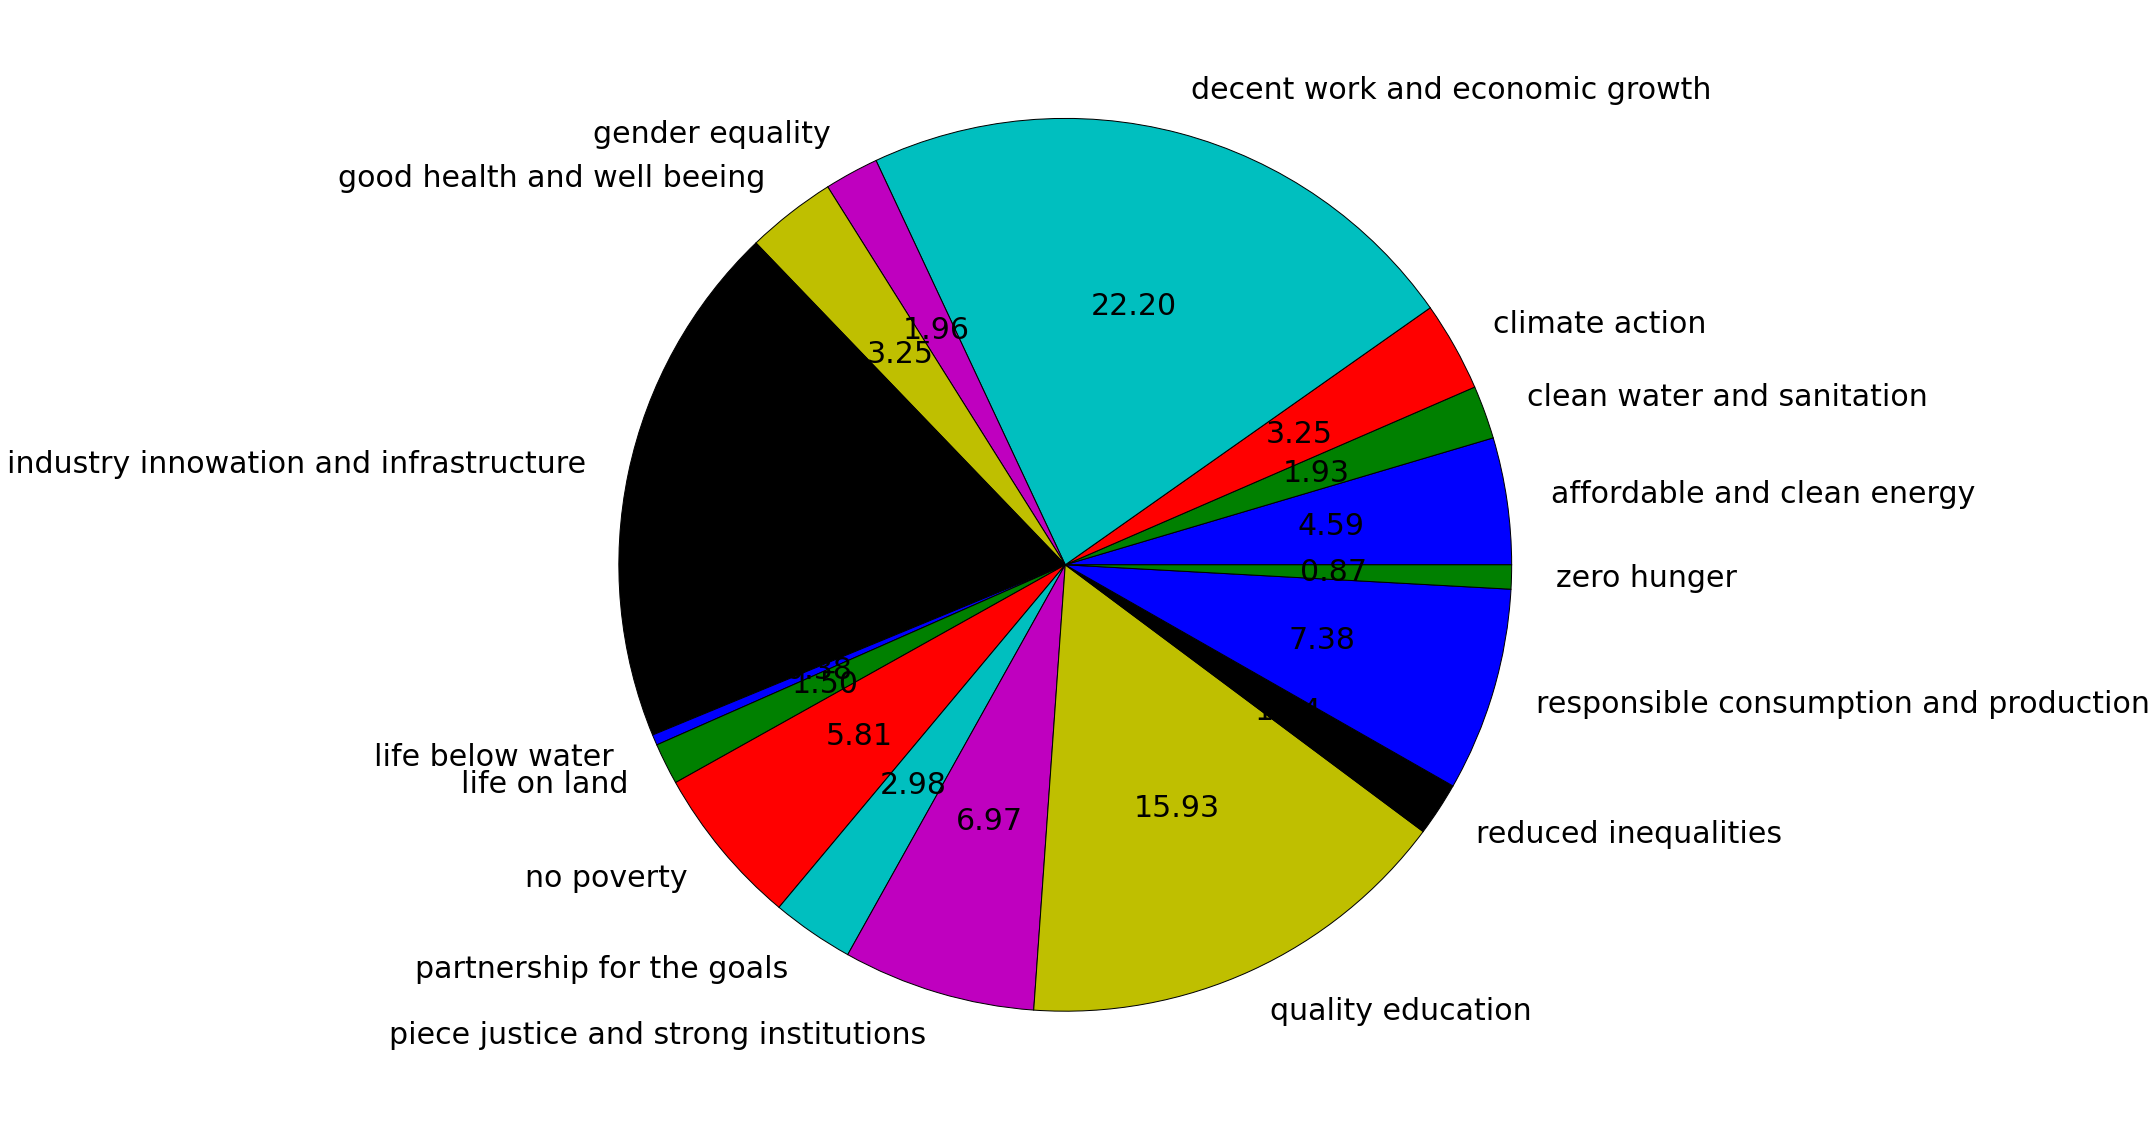

In [11]:
df_count_gen0.plot(kind='pie', subplots=True,
            autopct='%.2f', fontsize=30, figsize=(20, 20), legend = False)
plt.savefig('Pie.jpg', bbox_inches='tight')

In [12]:
general_count = dict()
count_gen = []
for i in xrange(len(general)):
    for j in xrange(len(general[i][1])):
        count_gen.append([general[i][0].split('.')[0], names[j], general[i][1][j][1]])        
    general_count[general[i][0]] = [x[1] for x in general[i][1]]
    
df_count_gen = pd.DataFrame(count_gen)
df_count_gen.to_csv("Journals_Categories_count.csv", index = False)

In [13]:
count_gen1 = []
for i in xrange(len(general)):
    for j in xrange(len(general[i][2])):
        count_gen1.append([names[j], general[i][2][j][1]])        
df_count_gen1 = pd.DataFrame(count_gen1)
df_count_gen1 = df_count_gen1.groupby([0]).sum()
df_count_gen1.columns = ['Causal link (->)']
df_count_gen1

,Causal link (->)
0,
affordable and clean energy,1625
clean water and sanitation,724
climate action,1158
decent work and economic growth,6123
gender equality,799
good health and well beeing,1215
industry innowation and infrastructure,9400
life below water,141
life on land,585


In [14]:
count_gen2 = []
for i in xrange(len(general)):
    for j in xrange(len(general[i][3])):
        count_gen2.append([names[j], general[i][3][j][1]])        
df_count_gen2 = pd.DataFrame(count_gen2)
df_count_gen2 = df_count_gen2.groupby([0]).sum()
df_count_gen2.columns = ['Causal link (<-)']
df_count_gen2

,Causal link (<-)
0,
affordable and clean energy,1848
clean water and sanitation,779
climate action,1281
decent work and economic growth,13009
gender equality,763
good health and well beeing,1406
industry innowation and infrastructure,6408
life below water,178
life on land,566


In [15]:
count_gen3 = []
for i in xrange(len(general)):
    for j in xrange(len(general[i][4])):
        count_gen3.append([names[j], general[i][4][j][1]])        
df_count_gen3 = pd.DataFrame(count_gen3)
df_count_gen3 = df_count_gen3.groupby([0]).sum()
df_count_gen3.columns = ['Constraint, barriers, challanges']
df_count_gen3

,"Constraint, barriers, challanges"
0,
affordable and clean energy,770
clean water and sanitation,420
climate action,583
decent work and economic growth,3197
gender equality,297
good health and well beeing,510
industry innowation and infrastructure,2703
life below water,59
life on land,241


In [16]:
count_gen4 = []
for i in xrange(len(general)):
    for j in xrange(len(general[i][5])):
        count_gen4.append([names[j], general[i][5][j][1]])        
df_count_gen4 = pd.DataFrame(count_gen4)
df_count_gen4 = df_count_gen4.groupby([0]).sum()
df_count_gen4.columns = ['Recommendatins']
df_count_gen4       


,Recommendatins
0,
affordable and clean energy,793
clean water and sanitation,233
climate action,557
decent work and economic growth,3304
gender equality,268
good health and well beeing,499
industry innowation and infrastructure,3101
life below water,43
life on land,266


In [34]:
result = pd.concat([df_count_gen1, df_count_gen2, df_count_gen3, df_count_gen4], axis=1)
result.loc[:, 'sum'] = result['Causal link (->)'] + result['Causal link (<-)'] + result['Constraint, barriers, challanges'] + result['Recommendatins']
result = result.sort(['sum'], ascending = True)
result =result.drop(['sum'], 1)
result.to_csv('Percentage_relation.csv')

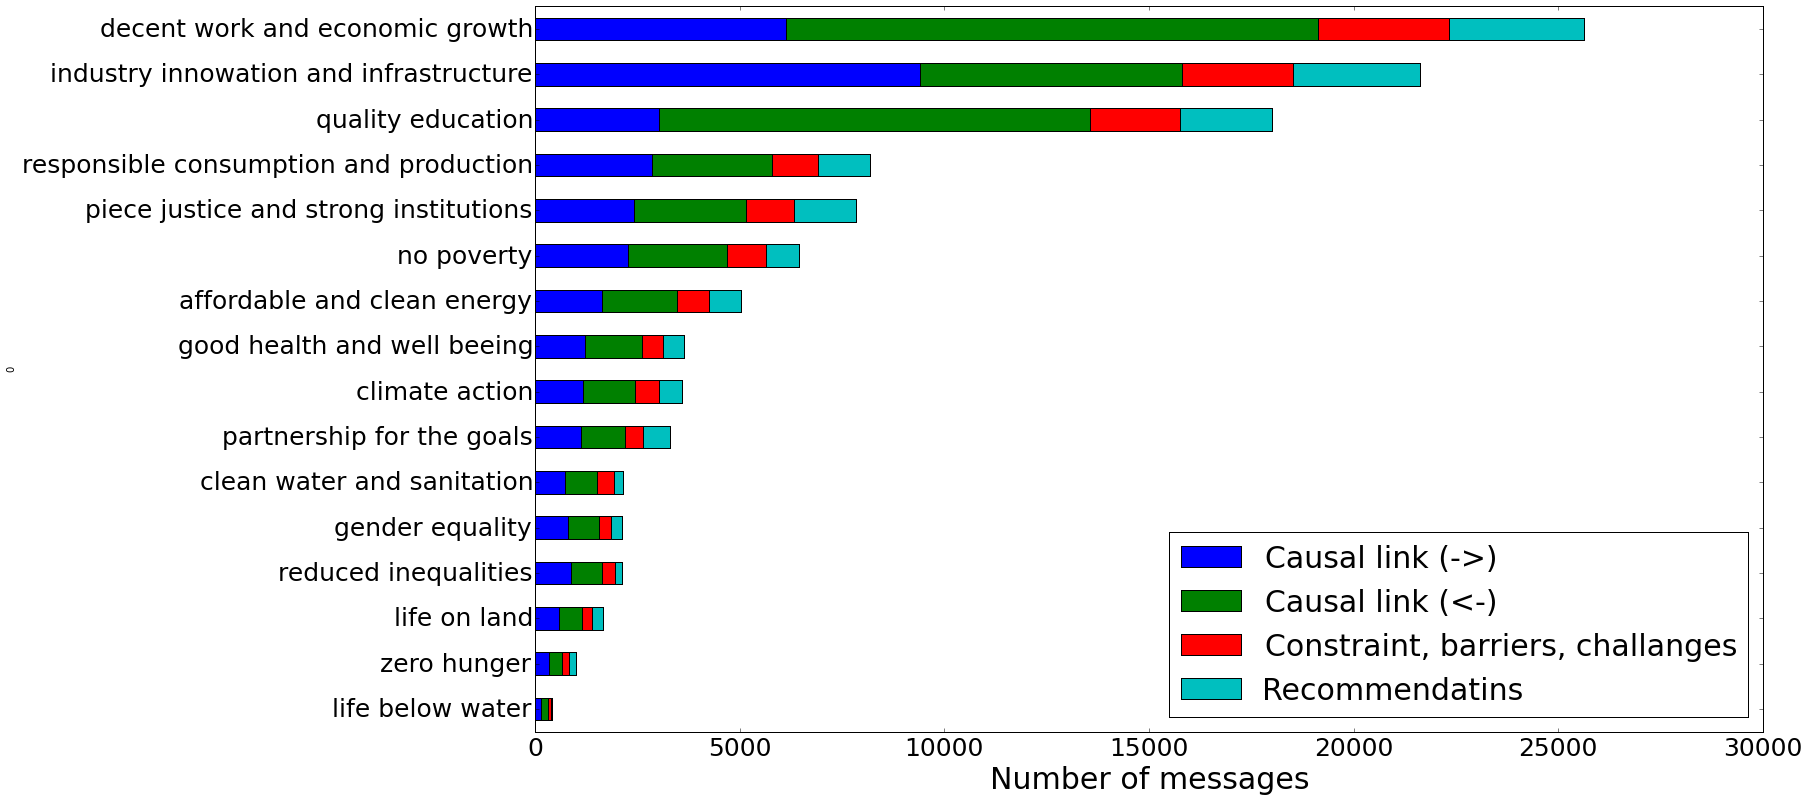

In [35]:

result.plot(kind='barh', stacked=True, figsize=(22, 13));
#plt.title("Percentage of relatioships for each link", size = 20)
plt.xticks(size = 25)
plt.yticks(size = 25)
#plt.ylabel('SDG', size = 20)
plt.xlabel('Number of messages', size = 30)
plt.legend(loc=4, prop={'size':30})
plt.savefig('Accuracy2.jpg', bbox_inches='tight')

In [26]:
category_count = []

for j in xrange(len(result.columns)):
    for i in xrange(len(result)):
        category_count.append([result.columns[j], result.index[i], result[result.columns[j]][result.index[i]]])

In [27]:
df_category_count = pd.DataFrame(category_count)
df_category_count.to_csv('Relationship_category_count.csv', index = False)

In [28]:
mergeData_general = mergeData[0]
for i in xrange(1, len(mergeData)):
    mergeData_general = mergeData_general.append(mergeData[i])
mergeData_general = mergeData_general.fillna('-0')

In [29]:
mergeData_general = mergeData_general[['text', 'common', 'constraint', 'recommendation', 'direction']]

In [30]:
mergeData_general = mergeData_general.fillna('-0')

In [31]:
mergeData_general.to_csv('mergeData_general.csv', index = False)

In [32]:
mergeData_general1

,SDG10Word,SDG11Word,SDG12Word,SDG13Word,SDG14Word,SDG15Word,SDG16Word,SDG17Word,SDG1Word,SDG2Word,...,SDG6Word,SDG7Word,SDG8Word,SDG9Word,common,constraint,direction,pNo,recommendation,text
0,-0,community,-0,-0,-0,-0,-0,-0,privation,-0,...,-0,-0,-0,-0,1,0,2,254,0,Putting in place by 2015 legislative administr...
1,-0,institutions,-0,-0,-0,-0,-0,-0,privation,-0,...,-0,-0,-0,-0,1,0,2,254,0,Putting in place by 2015 legislative administr...
2,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,0,0,2,456,1,taking into account the needs of women indigen...
3,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,1,0,1,501,0,Poor communities and women especially impacted...
4,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,0,0,2,2492,1,taking into account the needs of women indigen...
5,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,0,0,2,2495,1,By 2020 ecosystems that provide essential serv...
6,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,0,0,1,2498,1,This target directs attention towards the need...
7,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,0,0,2,2513,1,In the national reports there was little menti...
8,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,0,0,2,2515,1,Overall available evidence shows little sign o...
9,-0,community,-0,-0,-0,-0,-0,-0,poor,-0,...,-0,-0,-0,-0,1,0,2,2602,0,Restored landscapes and seascapes can improve ...
